In [ ]:
################### TO DO's ########################


# - Erklärungen hinzufügen: Was wurde warum gemacht
# - Bitte alle Blöcke durchlaufen lassen, auf Fehler kontrollieren und ggf. korrigieren. 
# - Textanalysen durchführen: 
#     evtl. wieder für einen Beispielartikel? -> abhängig von Analyse!
#     Feature Engineering
#     evtl. noch hinzufügen via api: Kategorie
#     ...

# Text Analyses

In the basic analysis, we were able to gain a basic overview of the data package.  
With the following text analysis we want to compare how the history of the articles has affected the text. To do this, we compare the original version of the text (initial creation) with the most recently available version of the same article. 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import datetime
import re
import urllib
import shutil
import matplotlib.image as mpimg
import time
import crawlerlib as cl
import wikipedia
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
import matplotlib as mpl

### Preparation

For our text analysis we have extended the crawlerlib with some functions: 

**Original Wiki-URL**

get whole url of first articleversion with pagetitle (wikititle)

In [2]:
def getOldSoup(wikititle):
	soup = requests.get("https://en.wikipedia.org/w/index.php?title="+wikititle+"&dir=prev&action=history")
	soup = BeautifulSoup(soup.content, 'html.parser')
	soup = soup.findAll("a", {"class": "mw-changeslist-date"})[0]['href']
	return 'https://en.wikipedia.org/'+soup

**Recent Wiki-URL**

get whole url of recent articleversion with pagetitle (wikititle)

In [3]:
def getRecentSoup(wikititle):
	wiki = 'https://en.wikipedia.org/wiki/'
	recent = wiki+wikititle
	return recent

**Wiki-Texts**

get original text and recent text per article

In [4]:
def getTextDF(urlis):
    textdf = pd.DataFrame(columns=['page_title', 'original', 'recent'])
    for i in range(len(urlis)):
        if str(getTextBody(urlis[i][0])).startswith('Redirect to'):
            continue
        else:
            s1 = str(getTextBody(urlis[i][0]))
            s2 = str(getTextBody(urlis[i][1]))
            textdf = textdf.append({'page_title' : str.rsplit(urlis[i][1], '/', 1)[-1], 'original' : s1, 'recent' : s2}, ignore_index=True)
    return textdf

**Vocabulary Density**

get vocabularity density for given text

In [5]:
def getVD(text):
  tokens = nltk.word_tokenize(text)
  tagged = nltk.pos_tag(tokens)
  nn = []
  ok = 'NN' 
  for i in tagged:
    if ok == i[1]:
      nn.append(i[0])
  nn1 = [re.sub('[^a-zA-Z0-9]+', '', _) for _ in nn]
  nn2 = []
  for i in nn1:
    if len(i) > 2:
      nn2.append(i)
    else:
      nn2.append('no text')
  try:
    VD = len(np.unique(nn2)) / len(nn2)
  except ZeroDivisionError:
    VD = 1
  return VD

**Words per Sentence**

get words per sentence for given text

In [6]:
def getWPS(text):
  tokens = nltk.word_tokenize(text)
  words = tokens
  sentences = [[]]
  ends = set(".?!;:")
  for word in words:
    if word in ends: 
      sentences.append([])
    else: 
      sentences[-1].append(word)
  if sentences[0]:
    if not sentences[-1]: sentences.pop()
    wps = sum(len(s) for s in sentences)/len(sentences)
    #print("average words per sentence: ", wps)
    return wps

**Words per Text**

get words per text for given text

In [7]:
def getWPT(text):
    tokens = nltk.word_tokenize(text)
    words = tokens
    sentences = [[]]
    for word in words:
        sentences.append([word])
    wpt = len(sentences)
    return wpt

**Generating new DataFrame**

In [8]:
df = pd.read_csv('p1p857.csv', index_col=0)
df.head()

,page_id,page_title,revision_id,timestamp,comment,contributor_id,contributor_name,bytes,revtext,dates,times,revbytes,revperc
0,10,AccessibleComputing,233192,2001-01-21 02:12:21,*,99,RoseParks,124,This subject covers* AssistiveTechnology* Acce...,2001-01-21,02:12:21,2848,4.353933
1,10,AccessibleComputing,862220,2002-02-25 15:43:11,Automated conversion,1226483,Conversion script,35,#REDIRECT [[Accessible Computing]],2002-02-25,15:43:11,2848,1.228933
2,10,AccessibleComputing,15898945,2003-04-25 22:18:38,Fixing redirect,7543,Ams80,34,#REDIRECT [[Accessible_computing]],2003-04-25,22:18:38,2848,1.193820
3,10,AccessibleComputing,56681914,2006-06-03 16:55:41,fix double redirect,516514,Nzd,36,#REDIRECT [[Computer accessibility]],2006-06-03,16:55:41,2848,1.264045
4,10,AccessibleComputing,74466685,2006-09-08 04:16:04,cat rd,750223,Rory096,57,#REDIRECT [[Computer accessibility]] {{R from ...,2006-09-08,04:16:04,2848,2.001404


Taking a look at the Page Titles

In [10]:
titles = df['page_title'].unique()
titles[:100]

array(['AccessibleComputing', 'Anarchism', 'AfghanistanHistory',
       'AfghanistanGeography', 'AfghanistanPeople',
       'AfghanistanCommunications', 'AfghanistanTransportations',
       'AfghanistanMilitary', 'AfghanistanTransnationalIssues',
       'AssistiveTechnology', 'AmoeboidTaxa', 'Autism', 'AlbaniaHistory',
       'AlbaniaPeople', 'AsWeMayThink', 'AlbaniaGovernment',
       'AlbaniaEconomy', 'Albedo', 'AfroAsiaticLanguages',
       'ArtificalLanguages', 'AbacuS', 'AbalonE', 'AbbadideS', 'AbbesS',
       'AbbevilleFrance', 'AbbeY', 'AbboT', 'Abbreviations',
       'AtlasShrugged', 'ArtificialLanguages', 'AtlasShruggedCharacters',
       'AtlasShruggedCompanies', 'AyersMusicPublishingCompany',
       'Talk:Atlas Shrugged', 'AfricanAmericanPeople', 'AdolfHitler',
       'AbeceDarians', 'AbeL', 'AbensbergGermany', 'AberdeenSouthDakota',
       'ArthurKoestler', 'AynRand', 'AlexanderTheGreat',
       'AnchorageAlaska', 'ArgumentForms',
       'ArgumentsForTheExistenceOfGod', 'An

get URLs of original and recent textversion of every article in the df

In [11]:
original = []
recent = []

for i in df['page_title'].unique():
    original.append(getOldSoup(i))
    recent.append(getRecentSoup(i))

store tuples in list: [(original url, recent url)]

In [12]:
urlis = list(zip(original, recent))

create new dataframe with title, original and recent

In [ ]:
textdf = cl.getTextDF(urlis)

In [17]:
textdf.head()

,page_title,original,recent
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)...."
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The..."
3,Talk:Atlas Shrugged,Cleanup&lt;/ 1 Cleanup2 Bias of 'Influences a...,class=ext-discussiontools-init-sectionExtern...
4,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...


Remove all page titles starting with the strings 'talk' or 'user' and clear table from page titles containing 'disambiguation'

In [18]:
filter = (~textdf['page_title'].str.contains('^Talk:')) & (~textdf['page_title'].str.contains('^User:')) & (~textdf['page_title'].str.contains('disambiguation'))

In [19]:
textdf1 = textdf[filter]
textdf1.head()

,page_title,original,recent
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)...."
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The..."
4,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...
6,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...


check, if all 'old' entries (written without space) are eliminated and how many titles are left

In [20]:
print( 'entries: ', len(textdf['page_title']), '\n', textdf1['page_title'].unique()[:10], '...')

entries:  160 
 ['Anarchism' 'Autism' 'Albedo' 'A' 'Alabama' 'Achilles' 'Abraham Lincoln'
 'Aristotle' 'An American in Paris'
 'Academy Award for Best Production Design'] ...


create new columns with VD of old entries and VD of recent entries

In [22]:
originalVD = []

for i in textdf1['original']:
    originalVD.append(getVD(i))

In [23]:
recentVD = []

for i in textdf1['recent']:
    recentVD.append(getVD(i))

In [25]:
VDs = list(zip(originalVD, recentVD))
VDs[:10]

[(0.6679389312977099, 0.4892550143266476),
 (0.3984375, 0.4991896272285251),
 (0.5688888888888889, 0.4405940594059406),
 (0.5380710659898477, 0.47191011235955055),
 (0.6388888888888888, 0.4564404061998931),
 (0.6948051948051948, 0.5503626107977437),
 (0.4174454828660436, 0.5529847292919945),
 (0.6317135549872123, 0.4979683972911964),
 (0.9090909090909091, 0.6476868327402135),
 (0.8488372093023255, 0.8636363636363636)]

In [ ]:
textdf1['originalVD'] = originalVD

In [ ]:
textdf1['recentVD'] = recentVD

In [28]:
textdf1.head()

,page_title,original,recent,originalVD,recentVD
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594
4,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910
6,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440


create new columns for oldest and recent entries: words per text

In [29]:
originalWPT = []

for i in textdf1['original']:
    originalWPT.append(getWPT(i))

In [30]:
recentWPT = []

for i in textdf1['recent']:
    recentWPT.append(getWPT(i))

In [ ]:
textdf1['originalWPT'] = originalWPT
textdf1['recentWPT'] = recentWPT

In [32]:
textdf1.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152
4,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386
6,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683


create columns for words per sentence for original and recent text

In [33]:
originalWPS = []

for i in textdf1['original']:
    originalWPS.append(getWPS(i))

In [34]:
recentWPS = []

for i in textdf1['recent']:
    recentWPS.append(getWPS(i))

In [ ]:
textdf1['originalWPS'] = originalWPS
textdf1['recentWPS'] = recentWPS

In [36]:
textdf1.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT,originalWPS,recentWPS
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518,32.326923,25.161692
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320,25.781250,84.116279
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152,51.777778,152.777778
4,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386,33.681818,25.208791
6,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683,13.441176,93.358621


add new column with number of revisions of the article

In [37]:
textdf2 = pd.merge(textdf1, df.groupby(['page_title']).agg({'revision_id' : 'count'}).reset_index(), how='left')
textdf2.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT,originalWPS,recentWPS,revision_id
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518,32.326923,25.161692,19961.0
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320,25.781250,84.116279,10646.0
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152,51.777778,152.777778,1253.0
3,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386,33.681818,25.208791,4802.0
4,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683,13.441176,93.358621,10202.0


add new column with number of contributors per article

In [38]:
textdf3 = pd.merge(textdf2, df.groupby(['page_title']).agg({'contributor_id' : pd.Series.nunique}).reset_index(), how='left')
textdf3.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT,originalWPS,recentWPS,revision_id,contributor_id
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518,32.326923,25.161692,19961.0,3797.0
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320,25.781250,84.116279,10646.0,3757.0
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152,51.777778,152.777778,1253.0,701.0
3,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386,33.681818,25.208791,4802.0,2609.0
4,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683,13.441176,93.358621,10202.0,4485.0


add column for unique contributor names (to compare, if given name or anon...)

In [39]:
textdf4 = pd.merge(textdf3, df.groupby(['page_title']).agg({'contributor_name' : pd.Series.nunique}).reset_index(), how='left')
textdf4.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT,originalWPS,recentWPS,revision_id,contributor_id,contributor_name
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518,32.326923,25.161692,19961.0,3797.0,1918.0
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320,25.781250,84.116279,10646.0,3757.0,1885.0
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152,51.777778,152.777778,1253.0,701.0,448.0
3,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386,33.681818,25.208791,4802.0,2609.0,1448.0
4,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683,13.441176,93.358621,10202.0,4485.0,2260.0


add column for number of dates on which a revision was made

In [40]:
textdf5 = pd.merge(textdf4, df.groupby(['page_title']).agg({'dates' : pd.Series.nunique}).reset_index(), how='left')
textdf5.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT,originalWPS,recentWPS,revision_id,contributor_id,contributor_name,dates
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518,32.326923,25.161692,19961.0,3797.0,1918.0,3216.0
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320,25.781250,84.116279,10646.0,3757.0,1885.0,2537.0
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152,51.777778,152.777778,1253.0,701.0,448.0,731.0
3,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386,33.681818,25.208791,4802.0,2609.0,1448.0,1489.0
4,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683,13.441176,93.358621,10202.0,4485.0,2260.0,3119.0


filter basicdf to get the sum of revised bytes per article without duplicates

In [41]:
df1 = df.drop_duplicates(subset='revbytes', keep="first", inplace=False)
df1.head()

,page_id,page_title,revision_id,timestamp,comment,contributor_id,contributor_name,bytes,revtext,dates,times,revbytes,revperc
0,10,AccessibleComputing,233192,2001-01-21 02:12:21,*,99,RoseParks,124,This subject covers* AssistiveTechnology* Acce...,2001-01-21,02:12:21,2848,4.353933
14,12,Anarchism,18201,2002-02-25 15:00:22,Automated conversion,1226483,Conversion script,9546,[[talk:Anarchism/Talk]] <br>[[Anarchism/Todo/T...,2002-02-25,15:00:22,1689954733,0.000565
19975,13,AfghanistanHistory,176453,2002-02-25 15:43:11,Automated conversion,1226483,Conversion script,34,#REDIRECT [[Afghanistan/History]],2002-02-25,15:43:11,787,4.320203
19981,14,AfghanistanGeography,233198,2001-01-21 23:00:32,*,32609824,LinusTolke,1663,"Irrigated land: 30,000 sq km (1993 est.) Natur...",2001-01-21,23:00:32,1988,83.651911
19988,15,AfghanistanPeople,133439,2002-02-25 15:43:11,Automated conversion,1226483,Conversion script,33,#REDIRECT [[Afghanistan/People]],2002-02-25,15:43:11,1993,1.655795


merge filtered df with latest textdf

In [42]:
textdf6 = pd.merge(textdf5, df1[['page_title', 'revbytes']], on='page_title', how='left')
textdf6.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT,originalWPS,recentWPS,revision_id,contributor_id,contributor_name,dates,revbytes
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518,32.326923,25.161692,19961.0,3797.0,1918.0,3216.0,1.689955e+09
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320,25.781250,84.116279,10646.0,3757.0,1885.0,2537.0,9.503834e+08
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152,51.777778,152.777778,1253.0,701.0,448.0,731.0,3.025434e+07
3,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386,33.681818,25.208791,4802.0,2609.0,1448.0,1489.0,4.717380e+07
4,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683,13.441176,93.358621,10202.0,4485.0,2260.0,3119.0,1.130464e+09


add column revgb to make revbytes easier to read (calculate gb)

In [43]:
textdf6['revgb'] = textdf6['revbytes']/1e+9
textdf6.head()

,page_title,original,recent,originalVD,recentVD,originalWPT,recentWPT,originalWPS,recentWPS,revision_id,contributor_id,contributor_name,dates,revbytes,revgb
0,Anarchism,Anarchism is a name taken by various political...,"For other uses,see Anarchism (disambiguation)....",0.667939,0.489255,1733,10518,32.326923,25.161692,19961.0,3797.0,1918.0,3216.0,1.689955e+09,1.689955
1,Autism,Autism is a complex pervasive developmental di...,This article is about the classic autistic dis...,0.398438,0.499190,857,7320,25.781250,84.116279,10646.0,3757.0,1885.0,2537.0,9.503834e+08,0.950383
2,Albedo,"In climatology,the albedo of a surface is the ...","For other uses,see Albedo (disambiguation).The...",0.568889,0.440594,1426,4152,51.777778,152.777778,1253.0,701.0,448.0,731.0,3.025434e+07,0.030254
3,A,The letter A is the first letter in the Roman ...,This article is about the Roman letter.For oth...,0.538071,0.471910,1527,2386,33.681818,25.208791,4802.0,2609.0,1448.0,1489.0,4.717380e+07,0.047174
4,Alabama,Alternate meanings: See Alabama (disambiguatio...,This article is about the U.S.state.For the ri...,0.638889,0.456440,491,13683,13.441176,93.358621,10202.0,4485.0,2260.0,3119.0,1.130464e+09,1.130464


start exploring...

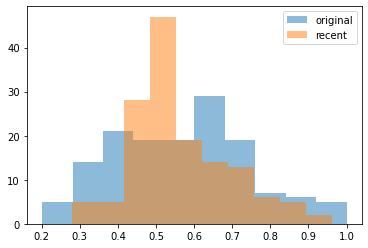

In [57]:
plt.hist(np.sort(textdf6['originalVD']), alpha = 0.5, label = 'original')
plt.hist(np.sort(textdf6['recentVD']), alpha = 0.5, label = 'recent')
plt.legend()

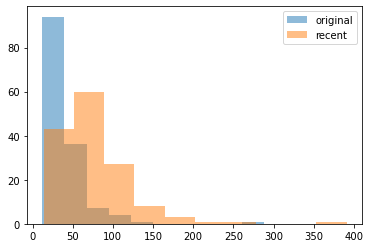

In [54]:
plt.hist(np.sort(textdf6['originalWPS']), alpha = 0.5, label = 'original')
plt.hist(np.sort(textdf6['recentWPS']), alpha = 0.5, label = 'recent')
plt.legend()

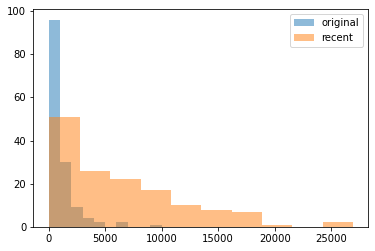

In [56]:
plt.hist(np.sort(textdf6['originalWPT']), alpha = 0.5, label = 'original')
plt.hist(np.sort(textdf6['recentWPT']), alpha = 0.5, label = 'recent')
plt.legend()

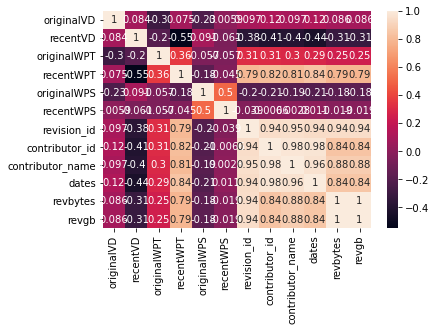

In [46]:
corrMatrix = textdf6.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()